In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'bigquery-ethereum-403902' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=bigquery-ethereum-403902:US:bquxjob_679c04ce_18c5aea251c)
back to BigQuery to edit the query within the BigQuery user interface.

In [15]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_2d8659fe_18c5af4187c') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT
  EXTRACT(YEAR FROM block_timestamp) as year,
  EXTRACT(MONTH FROM block_timestamp) as month,
  EXTRACT(DAY FROM block_timestamp) as day,
  SUM(IF(transaction_type <> 2, 1, 0)) as sum_legacy,
  COUNT(*) as transaction_count
FROM bigquery-public-data.goog_blockchain_ethereum_mainnet_us.transactions t
WHERE block_timestamp >= '2020-01-01'
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3



# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [9]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_2d8659fe_18c5af4187c') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,year,month,day,sum_legacy,transaction_count
0,2020,1,1,466526,466526
1,2020,1,2,505639,505639
2,2020,1,3,581641,581641
3,2020,1,4,559074,559074
4,2020,1,5,524664,524664
...,...,...,...,...,...
1436,2023,12,7,180635,1159526
1437,2023,12,8,173897,1182465
1438,2023,12,9,176196,1120555
1439,2023,12,10,169887,1129096


## Show descriptive statistics using describe()
Use the ```pandas DataFrame.describe()```
[method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [10]:
results.describe()

,year,month,day,sum_legacy,transaction_count
count,1441.0,1441.0,1441.0,1441.0,1441.0
mean,2021.47814,6.446912,15.649549,583436.882026,1093317.442748
std,1.112293,3.412415,8.811373,448782.916444,181033.342121
min,2020.0,1.0,1.0,109841.0,428839.0
25%,2020.0,3.0,8.0,175832.0,1018353.0
50%,2021.0,6.0,16.0,416090.0,1109206.0
75%,2022.0,9.0,23.0,1071389.0,1197340.0
max,2023.0,12.0,31.0,1716600.0,1932711.0


In [76]:
results['date'] = results.apply(lambda row: str(row['year']) + '-' + ('0' + str(row['month']))[-2:] + '-' + ('0' + str(row['day']))[-2:], axis=1)

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def show_metric(metric, title='', moving_average=False):
  TICK_SIZE = 50
  N = 30

  ticks = [i * TICK_SIZE for i in range(0, len(results) // TICK_SIZE + 1)]

  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.xticks(ticks, results.iloc[ticks]['date'].values, rotation=90)
  if type(metric) == str:
    plt.plot(results[metric].values)
  else:
    plt.plot(metric)
  if moving_average:
    plt.plot([i for i in range(N - 1, len(results))], np.convolve(results[metric].values, np.ones(N) / N, mode='valid'))
    plt.legend([metric, f'Average Last {N}'])
  plt.show()

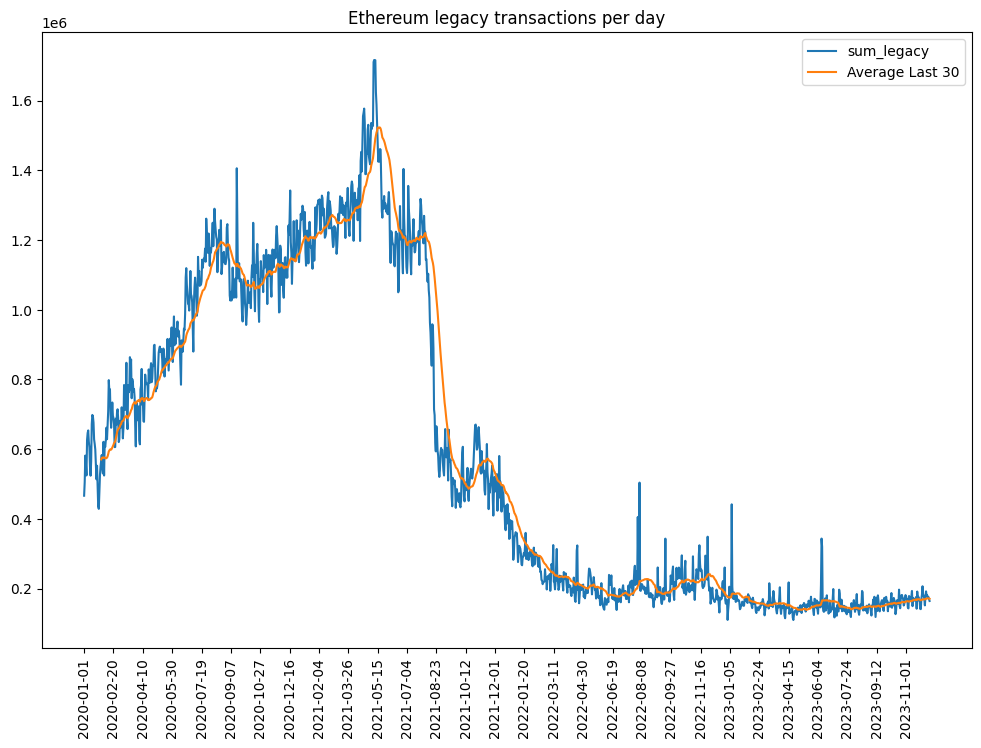

In [86]:
show_metric('sum_legacy', 'Ethereum legacy transactions per day', moving_average=True)

In [23]:
results.loc[600]

year                    2021
month                      8
day                       23
sum_legacy            665811
transaction_count    1245624
Name: 600, dtype: Int64

In [17]:
results.loc[700]

year                    2021
month                     12
day                        1
sum_legacy            478529
transaction_count    1221643
Name: 700, dtype: Int64

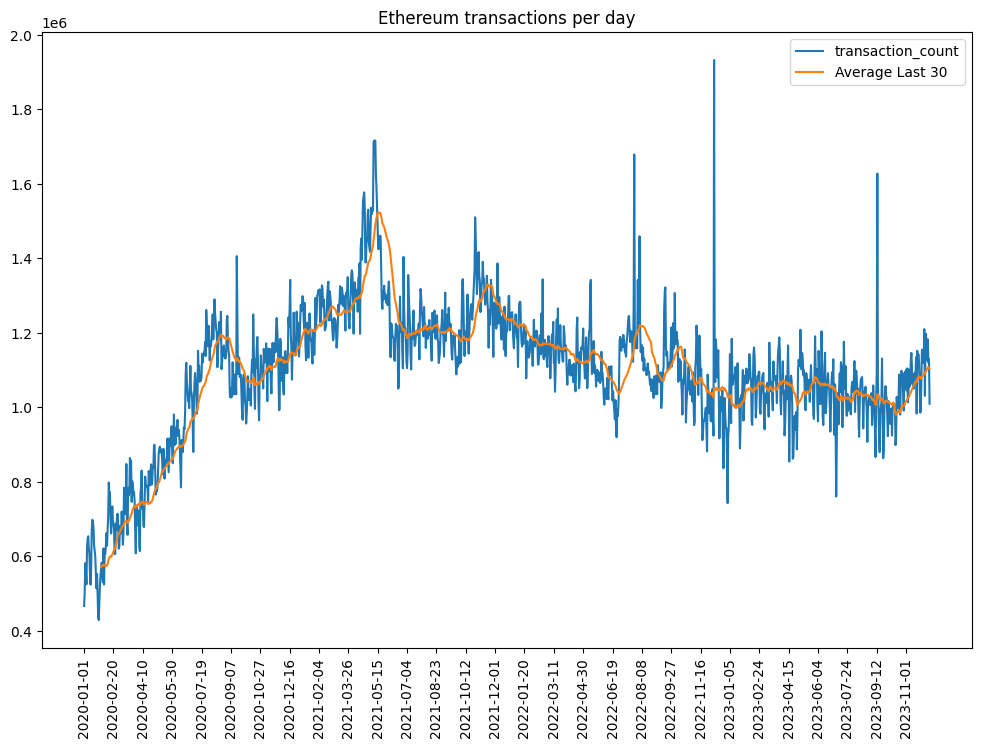

In [82]:
show_metric('transaction_count', 'Ethereum transactions per day', moving_average=True)

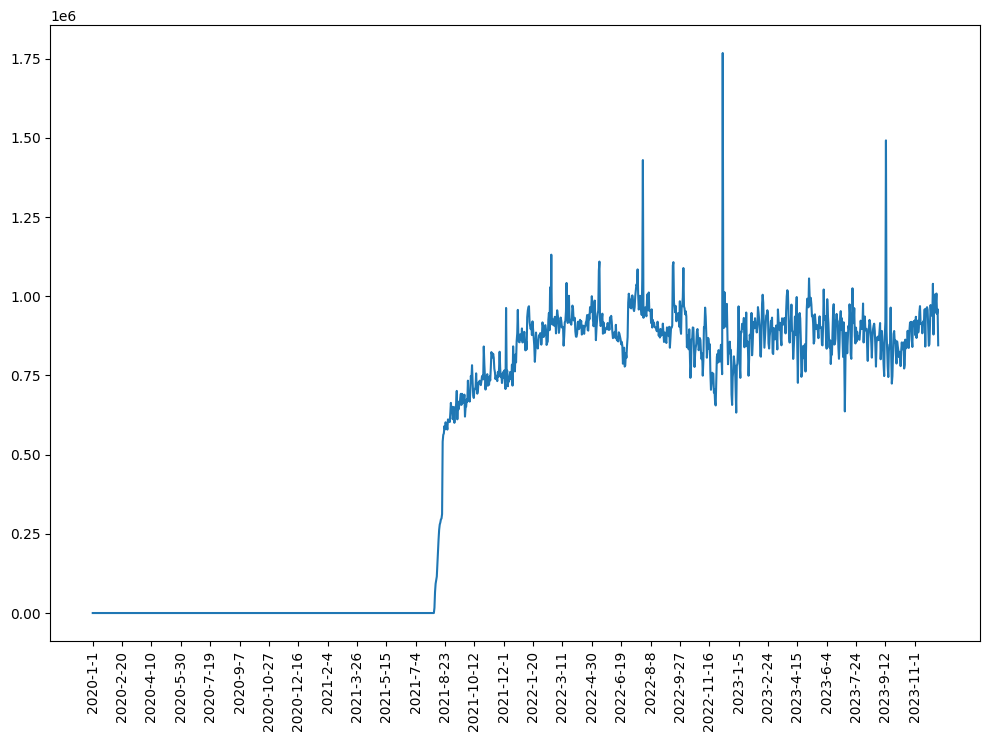

In [48]:
show_metric(results['transaction_count'].values - results['sum_legacy'].values)

In [49]:
results.iloc[0]

year                     2020
month                       1
day                         1
sum_legacy             466526
transaction_count      466526
date                 2020-1-1
Name: 0, dtype: object